### Домашнее задание Transformers Training (50 баллов)

В этом домашнем задании требуется обучить несколько Transformer-based моделей в задаче машинного перевода. Для обучения можно воспользоваться текущим проектом, так и реализовать свой пайплайн обучения. Если будете использовать проект, теги **TODO** проекта отмечают, какие компоненты надо реализовать.
В ноутбуке нужно только отобразить результаты обучения и выводы. Архитектура модели(количетсво слоев, размерность и тд) остается на ваш выбор.

Ваш код обучения нужно выложить на ваш github, в строке ниже дать ссылку на него. В первую очередь будут оцениваться результаты в ноутбуке, код нужен для проверки адекватности результатов. 

Обучать модели до конца не нужно, только для демонстрации, что модель обучается и рабочая - снижение val_loss, рост bleu_score.

#### Сcылка на ваш github с проектом(вставить свой) - https://github.com/AlexeyKrylov/pytorch-machine-translation/

Ноутбук с результатами выкладывать на ваш **google диск** курса. 

### Данные

`
wget https://www.manythings.org/anki/rus-eng.zip && unzip rus-eng.zip
`

Модели нужно обучить на задаче перевода с английского на русский. 

In [1]:
import os
import re
import json
import matplotlib.pylab as plt

%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\krilo\anaconda3\envs\DiffuSeq_env\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


### Обучение Seq2seq Transformer модель(25 баллов)

Реализуйте Seq2seq Transformer. В качестве блока трансформера можно использовать https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html. В качестве токенизатора воспользуйтесь HuggingFace токенизатор для source/target языков - https://huggingface.co/docs/transformers/fast_tokenizers
В качестве максимальной длинны возьмите предложения длинной **до 15 слов**, без каких либо префиксов. 

Не забудьте остальные элементы модели:
* Мы можем использовать 1 трансформер как энкодер - декодером будет выступать линейный слой. 
* Обучите свой BPE токенизатор - https://huggingface.co/docs/transformers/fast_tokenizers
* Матрицу эмбеддингов токенов
* Матрицу позицонных эмбеддингов
* Линейный слой проекции в target словарь
* Функцию маскирования будущих состояний attention, так как модель авто-регрессионна
* Learning rate schedualer


В качестве результатов, приложите слудующие данные:
1) Параметры обучения - learning rate, batch_size, epoch_num, размерность скрытого слоя, количетсво слоев
2) Графики обучения - train loss, val loss, bleu score
3) Примеры переводов вашей модели(10 штук) - source text, true target text, predicted target text

In [142]:
MATCH_REGEX = re.compile(r"[+-]?\b(\d+([.]\d*)?([eE][+-]?\d+)?|[.]\d+([eE][+-]?\d+)?)\b")

def extract_values(string):
    result = dict()
    params = ['val_loss', 'train_loss', 'bleu_score']
    if "train_loss" in string:
        found_vals = [re_match[0] for re_match in re.findall(MATCH_REGEX, string)]
    
        if len(params) == len(found_vals):
            for name, val in zip(params, found_vals):
                result[name] = float(val)
    return result

def plot_results(train_loss_list, val_loss_list, val_bleu_list, run_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    
    ax1.plot(range(len(train_loss_list)), train_loss_list, label='train loss')
    ax1.plot(range(len(val_loss_list)), val_loss_list, label='val loss')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.legend()
    
    ax2.plot(range(len(val_bleu_list)), val_bleu_list, label='val bleu')
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('BLEU')
    ax2.legend()
    
    fig.suptitle(run_name, fontsize=20)
    plt.show()

In [143]:
DATAPATH = 'C:/Users/krilo/PycharmProjects/pytorch-machine-translation/training_logs_transformer'
progress_file_path = os.path.join(DATAPATH, "progress_log.txt")
file_content = open(progress_file_path, 'r').read().split("\n")

In [144]:
train_loss_list, val_loss_list, val_bleu_list = [], [], []
for line in file_content:
    d = extract_values(line)
    if len(d) > 0:
        train_loss_list.append(d['train_loss'])
        val_loss_list.append(d['val_loss'])
        val_bleu_list.append(d['bleu_score'])
    
        
len(train_loss_list), len(val_loss_list), len(val_bleu_list)

(80, 80, 80)

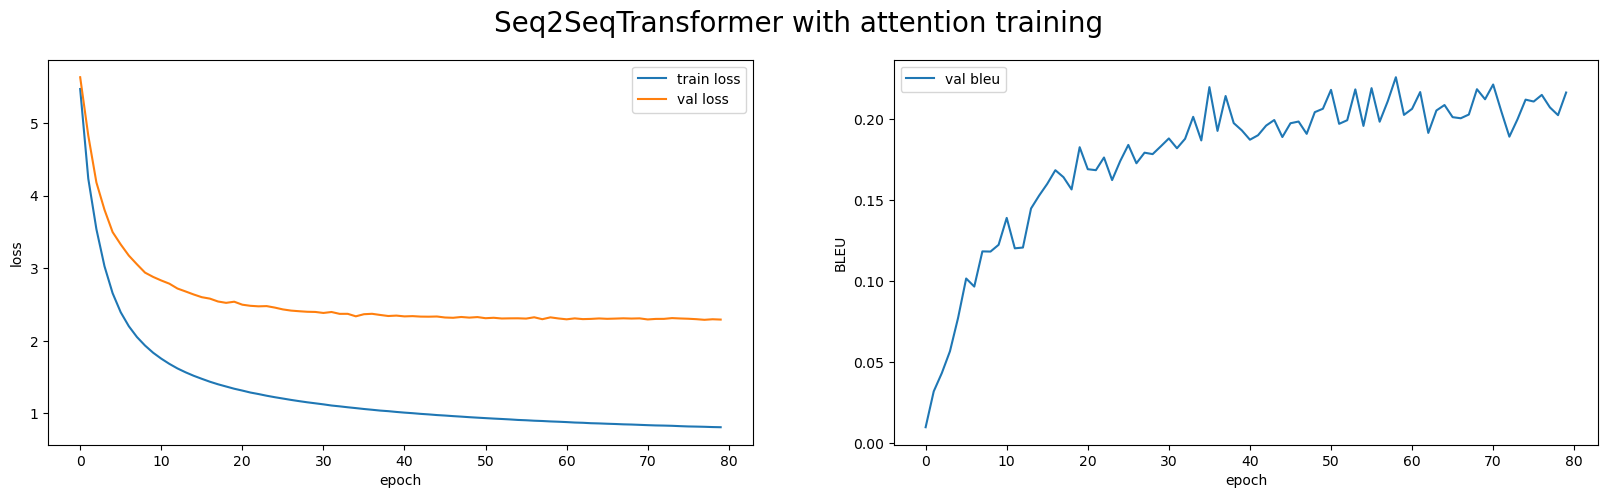

In [145]:
plot_results(train_loss_list, val_loss_list, val_bleu_list, run_name='Seq2SeqTransformer with attention training')

### Fine-tune pretrained T5 (25 баллов)

Реализуйте Seq2seq Pretrained T5. Воспользуйтесь https://huggingface.co/docs/transformers/model_doc/t5 предобученной моделью. В качестве максимальной длинны возьмите предложения длинной **до 15 слов**, без каких либо префиксов. Архитектура модели(количетсво слоев, размерность и тд) остается на ваш выбор.

Не забудьте важные аспекты обучения модели:
* Взять готовый t5 токенизатор
* Resize matrix embedding - скорей всего ваша матрица эмбеддингов не будет включать эмбеддинги из вашего сета. Пример обновления матрицы эмбеддингов тут тут https://github.com/runnerup96/Transformers-Tuning/blob/main/t5_encoder_decoder.py
* Learning rate schedualer/Adafactor with constant learning rate


В качестве результатов, приложите слудующие данные:
1) Параметры обучения - learning rate, batch_size, epoch_num, pretrained model name
2) Графики обучения - train loss, val loss, bleu score
3) Примеры переводов вашей модели(10 штук) - source text, true target text, predicted target text

In [122]:
MATCH_REGEX = re.compile(r"[+-]?\b(\d+([.]\d*)?([eE][+-]?\d+)?|[.]\d+([eE][+-]?\d+)?)\b")

def extract_values(string):
    result = dict()
    params = ['val_loss', 'train_loss', 'bleu_score']
    if "train_loss" in string:
        found_vals = [re_match[0] for re_match in re.findall(MATCH_REGEX, string)]
    
        if len(params) == len(found_vals):
            for name, val in zip(params, found_vals):
                result[name] = float(val)
    return result

def plot_results(train_loss_list, val_loss_list, val_bleu_list, run_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    
    ax1.plot(range(len(train_loss_list)), train_loss_list, label='train loss')
    ax1.plot(range(len(val_loss_list)), val_loss_list, label='val loss')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.legend()
    
    ax2.plot(range(len(val_bleu_list)), val_bleu_list, label='val bleu')
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('BLEU')
    ax2.legend()
    
    fig.suptitle(run_name, fontsize=20)
    plt.show()

In [123]:
DATAPATH = 'C:/Users/krilo/PycharmProjects/pytorch-machine-translation/training_logs/'
progress_file_path = os.path.join(DATAPATH, "progress_log.txt")
file_content = open(progress_file_path, 'r').read().split("\n")

In [124]:
train_loss_list, val_loss_list, val_bleu_list = [], [], []
for line in file_content:
    d = extract_values(line)
    if len(d) > 0:
        train_loss_list.append(d['train_loss'])
        val_loss_list.append(d['val_loss'])
        val_bleu_list.append(d['bleu_score'])
    
        
len(train_loss_list), len(val_loss_list), len(val_bleu_list)

(158, 158, 158)

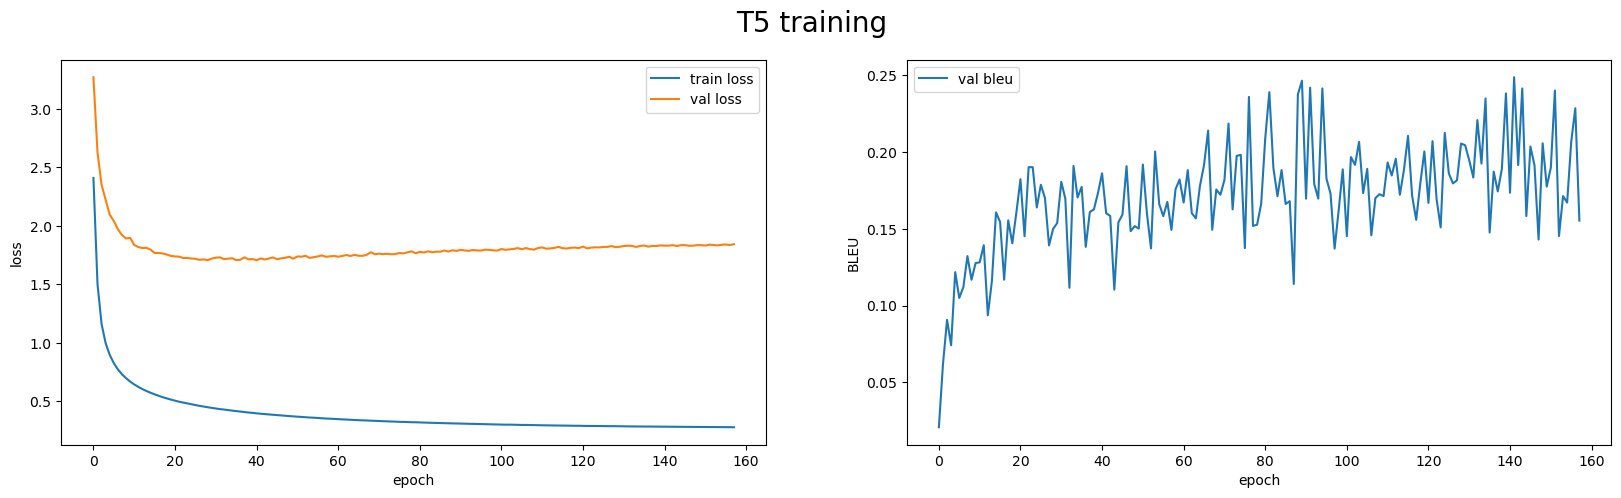

In [125]:
plot_results(train_loss_list, val_loss_list, val_bleu_list, run_name='T5 training')